### Imports

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import random

from pathlib import Path
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

### Device

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Constants

In [3]:
BATCH_SIZE = 32
INPUT_SIZE = 6
NUM_LAYERS = 3
NUM_EPOCHS = 10
DATA_DIR = Path('../data/dataset/')
LOOKBACK = 5
LOWEST_FREQUENCY = 50
KERNEL_SIZE = 3
SUBSET = ['imu', 'odom', 'cmd_vel', 'servo']

### Load and split data

In [4]:
with open('../data/labels.json') as fp:
    labels = json.load(fp)

In [5]:
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in ('4W', '6W') and values['spacing'] == 'R1']

In [6]:
X = pd.Series([run[0] for run in dataset], name='bag_name')
y_primary = [run[1] for run in dataset]

In [7]:
# y_secondary = ['slippery' if label in ('1_Panele', '5_Spienione_PCV', '6_Linoleum')
#                else 'grippy' if label in ('3_Wykladzina_jasna', '8_Pusta_plyta', '9_podklady')
#                else 'neutral' for label in y_primary]
y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
               else 'grippy' if label in ('5_Spienione_PCV', '8_Pusta_plyta', '9_podklady', '10_Mata_ukladana')
               else 'neutral' for label in y_primary] # Pawel set
# y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
#                else 'grippy' if label in ('2_Wykladzina_czarna', '5_Spienione_PCV', '9_podklady', '10_Mata_ukladana')
#                else 'neutral' for label in y_primary] # Clustering set

In [8]:
le = LabelEncoder()
le.fit(y_secondary)
classes = le.classes_
num_classes = len(classes)
y = le.transform(y_secondary)
y = y.reshape(-1, 1)

In [9]:
lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y)

In [10]:
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
original_indexing = X_test.index
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.2, stratify=y_training)
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

### Custom datasets

In [11]:
def select_sequence(series, selected_columns, window_length, stride):
    series = series[selected_columns]
    initial_timestep = random.randint(0, (len(series) - 1) - window_length)
    final_timestep = initial_timestep + window_length
    timesteps = list(range(initial_timestep, final_timestep + stride, stride))
    return series.iloc[timesteps].to_numpy()

In [12]:
class SurfaceDataset(Dataset):
    def __init__(self, samples, labels, frequency=50, lookback=1, subset=None):
        """        
        Args:
            samples: An array of time series, first dimension is time steps
            labels: An array of surface labels
            frequency: The lowest frequency of collected data
            lookback: Size of window for prediction
        """

        self.samples = samples
        self.labels = labels
        self.frequency = frequency
        self.lookback = int(lookback * self.frequency)
        self.stride = int(300 / self.frequency)
        self.window_length = self.lookback * self.stride
        if subset:
            self.subset = set(subset)
        else:
            self.subset = ('cmd_vel', 'imu', 'odom', 'servo')
        measurements = {
            'cmd_vel': ['linear.x', 'angular.z'],
            'imu': ['linear_acceleration.x', 'linear_acceleration.y', 'linear_acceleration.z', 'angular_velocity.x', 'angular_velocity.y', 'angular_velocity.z'],
            'odom': ['pose.pose.position.x', 'pose.pose.position.y', 'twist.twist.linear.x', 'twist.twist.angular.z'],
            'servo': ['values'],
        }
        self.selected_columns = []
        for measurement in self.subset:
            self.selected_columns.extend(measurements[measurement])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieve a single, windowed time series from dataset
        """

        sample = self.samples[idx]
        run = pd.read_csv(sample, index_col=[0]).drop('Time', axis=1)
        
        X = select_sequence(run, self.selected_columns, self.window_length, self.stride)
        y = self.labels[idx]
        
        return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)
    
train_dataloader = DataLoader(SurfaceDataset(X_train, y_train, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(SurfaceDataset(X_val, y_val, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=BATCH_SIZE)
test_dataloader = DataLoader(SurfaceDataset(X_test, y_test, frequency=LOWEST_FREQUENCY, lookback=LOOKBACK, subset=SUBSET), batch_size=1)

### Models

In [13]:
class LSTMSurfaceClassifier(nn.Module):
    def __init__(self, input_size=None, output_size=None, hidden_size=256, num_layers=3):
        super(LSTMSurfaceClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.8)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output in the sequence for classification
        return out

# Define model
hidden_size = 100
lstm_model = LSTMSurfaceClassifier(input_size=INPUT_SIZE, output_size=num_classes, hidden_size=hidden_size, num_layers=NUM_LAYERS).to(device)

In [14]:
class CNNSurfaceClassifier(nn.Module):
    def __init__(self, input_size=None, output_size=None, kernel_size=3, num_blocks=3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.num_blocks = num_blocks
        
        self.fc_pre = nn.Sequential(
            nn.Conv1d(self.input_size, 32, 7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
        )
        self.blocks = nn.Sequential(
            nn.Conv1d(32, 64, self.kernel_size, stride=2, padding=1), 
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 512, self.kernel_size, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc_post = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(512, self.output_size),
        )

    def forward(self, x):
        x = self.fc_pre(x)
        x = self.blocks(x)
        return self.fc_post(x)

cnn_model = CNNSurfaceClassifier(input_size=INPUT_SIZE, output_size=num_classes, kernel_size=KERNEL_SIZE, num_blocks=NUM_LAYERS).to(device)

In [15]:
summary(cnn_model)

Layer (type:depth-idx)                   Param #
CNNSurfaceClassifier                     --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       2,720
│    └─BatchNorm1d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool1d: 2-4                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-5                       6,208
│    └─BatchNorm1d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─Conv1d: 2-8                       24,704
│    └─BatchNorm1d: 2-9                  256
│    └─ReLU: 2-10                        --
│    └─Conv1d: 2-11                      98,560
│    └─BatchNorm1d: 2-12                 512
│    └─ReLU: 2-13                        --
│    └─Conv1d: 2-14                      393,728
│    └─BatchNorm1d: 2-15                 1,024
│    └─ReLU: 2-16                        --
├─Sequential: 1-3                        --
│    └─AdaptiveAvgPool1d: 2-17           --
│ 

### Loss function

In [16]:
criterion = nn.CrossEntropyLoss()

### Optimizer

In [17]:
optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr=1e-3,
    eps=1e-6,
    weight_decay=1e-3,
    )
scheduler = ExponentialLR(optimizer, gamma=0.9)

### Early stopping

In [18]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
early_stopper = EarlyStopper(patience=3, min_delta=1e-3)

### Training loop

In [25]:
train_batches = len(train_dataloader)
val_batches = len(val_dataloader)

for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0
    
    pbar = tqdm(train_dataloader, total=train_batches)
    cnn_model.train()
    for idx, (batch_x, batch_y) in enumerate(pbar):
        optimizer.zero_grad()
        
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        train_outputs = cnn_model(batch_x)
        train_loss = criterion(train_outputs, batch_y)
        running_train_loss += train_loss

        # Backward pass
        train_loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Training loss: {running_train_loss / (idx + 1):.2E}")
    scheduler.step()

    pbar_val = tqdm(val_dataloader, total=val_batches)
    cnn_model.eval()
    with torch.no_grad():
        for idx, (batch_x_val, batch_y_val) in enumerate(pbar_val):
            batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
            batch_x_val = batch_x_val.permute(0, 2, 1)
            val_outputs = cnn_model(batch_x_val)
            val_loss = criterion(val_outputs, batch_y_val)
            running_val_loss += val_loss
            
            pbar_val.set_description(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Validation loss: {running_val_loss / (idx + 1):.2E}")
            
    torch.save({
        'epoch': epoch,
        'model_state_dict': cnn_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': running_train_loss,
        'val_loss': running_val_loss,
    }, f"../data/checkpoints/cnn_classifier_{epoch + 1}.pt")

Epoch 10/10, Validation loss: 3.53E-01: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


### Test

In [26]:
test_batches = len(test_dataloader)
y_pred = []
running_test_loss = 0.0
misclassified = []

pbar_test = tqdm(test_dataloader, total=test_batches)
cnn_model.eval()
with torch.no_grad():
    for idx, (batch_x_test, batch_y_test) in enumerate(pbar_test):
        batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
        batch_x_test = batch_x_test.permute(0, 2, 1)
        test_outputs = cnn_model(batch_x_test)
        test_loss = criterion(test_outputs, batch_y_test)
        pred = torch.argmax(test_outputs).cpu().numpy()
        true = torch.argmax(batch_y_test).cpu().numpy()
        y_pred.append(pred)
        if pred != true:
            misclassified.append(original_indexing[idx])
        running_test_loss += test_loss
        
        pbar_test.set_description(f"Test loss: {running_test_loss / (idx + 1):.2E}")

misclassified_original = [y_primary[idx] for idx in misclassified]

Test loss: 4.15E-01: 100%|██████████| 268/268 [00:07<00:00, 34.65it/s]


### Confusion matrix

              precision    recall  f1-score   support

      grippy       0.76      0.73      0.74       107
     neutral       0.74      0.77      0.75       108
    slippery       1.00      1.00      1.00        53

    accuracy                           0.80       268
   macro avg       0.83      0.83      0.83       268
weighted avg       0.80      0.80      0.80       268


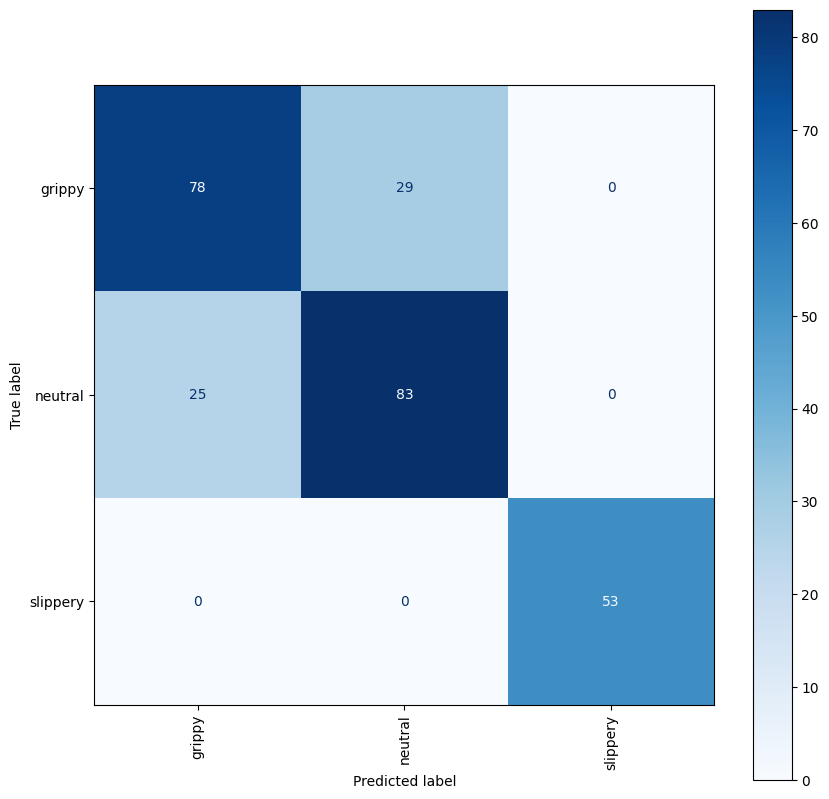

In [27]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 10))

# y_test = lb.inverse_transform(y_test)
print(classification_report(y_test, y_pred, target_names=classes))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=classes, xticks_rotation='vertical', cmap='Blues', ax=ax)

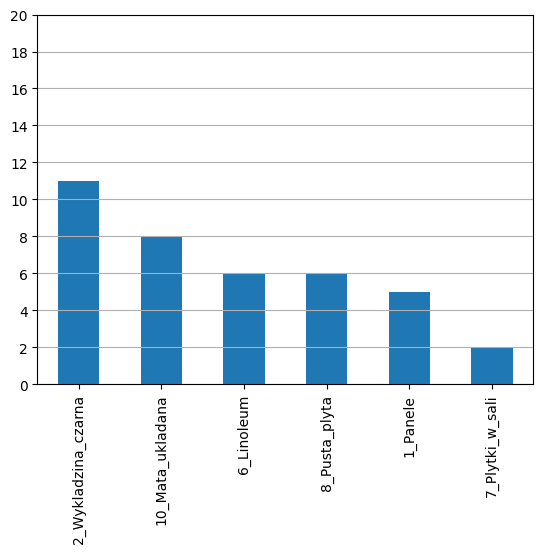

In [26]:
pd.Series(misclassified_original).value_counts().plot.bar()
plt.yticks(range(0, 21, 2))
plt.grid(axis='y')